# Multilayer perceptron in TensorFlow (plain vanilla)

In this script we build a small multilayer perceptron with two hidden layers having 500 and 50 neurons each for classifying the MNIST database of handwritten digits.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import numpy as np
import time
import tensorflow as tf
import pandas as pd
tf.set_random_seed(1)
np.random.seed(1)
import sys
tf.__version__, sys.version_info

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


('1.6.0',
 sys.version_info(major=3, minor=5, micro=2, releaselevel='final', serial=0))

In [2]:
# To be compatible with python3 and python2
try:
    import cPickle as pickle
except ImportError:
    import pickle
import gzip

with gzip.open('../data/mnist_4000.pkl.gz', 'rb') as f:
    if sys.version_info.major > 2:
        (X,y) = pickle.load(f, encoding='latin1')
    else:
        (X,y) = pickle.load(f)
PIXELS = len(X[0,0,0,:])

print(X.shape, y.shape, PIXELS) #As read
# We need to reshape for the MLP
X = X.reshape([4000, 784])
np.shape(X)

(4000, 1, 28, 28) (4000,) 28


(4000, 784)

In [3]:
# Taken from http://stackoverflow.com/questions/29831489/numpy-1-hot-array
def convertToOneHot(vector, num_classes=None):
    result = np.zeros((len(vector), num_classes), dtype='int32')
    result[np.arange(len(vector)), vector] = 1
    return result

## Building the network
Build a network with the following architecture.

### Definition of the network (architecture)

* An Input Layer with the following 2-dimensions: 
    * 0: Batch Size yet unkown hence `None`
    * 1: 784 = 28*28 pixels
* A hidden layer with 500 units
* A second hidden layer with 50 units
* An output layer with 10 units

### Hints
* The weights can be specified and intitialized as
```{python}
    w_1 = tf.Variable(tf.random_normal([784, 500]))
```
* Use ```tf.nn.sigmoid``` activations for the hidden layer

In [4]:
tf.reset_default_graph()
tf.set_random_seed(1)
x = tf.placeholder(tf.float32, shape=[None, 784], name='x_data')
y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_data')

# From Input to first hidden layer
w_1 = tf.Variable(tf.random_normal([784, 500], stddev=0.1))
b_1 = tf.Variable(tf.random_normal([500]))
h_1_in = tf.add(tf.matmul(x, w_1), b_1)
h_1_out = tf.nn.sigmoid(h_1_in)

# From first hidden layer to second hidden layer
# <--- Your code here --->
w_2 = tf.Variable(tf.random_normal([500, 50], stddev=0.1))
b_2 = tf.Variable(tf.random_normal([50]))
h_2_in = tf.add(tf.matmul(h_1_out, w_2), b_2)
h_2_out = tf.nn.sigmoid(h_2_in)
# <--- End of your code here --->

# From second hidden layer to output
w_3 = tf.Variable(tf.random_normal([50, 10], stddev=0.1))
b_3 = tf.Variable(tf.random_normal([10]))
h_3_in = tf.add(tf.matmul(h_2_out, w_3), b_3)

# Output is softmax
out = tf.nn.softmax(h_3_in)
init_op = tf.global_variables_initializer() 

### Store the graph and visualize it in tensorflow

In [5]:
tf.summary.FileWriter("tmp/fcn_minst_tensorflow/", tf.get_default_graph()) #<--- Where to store

### Doing a forward pass of the untrained network

In [6]:
with tf.Session() as sess:
    sess.run(init_op)
    res_val = sess.run(out, feed_dict={x:X[0:2]})
res_val

array([[0.2901188 , 0.07582619, 0.09984875, 0.05227003, 0.01745035,
        0.04776024, 0.09137144, 0.03255811, 0.26810396, 0.0246921 ],
       [0.27193338, 0.07854532, 0.09609108, 0.06423978, 0.0168191 ,
        0.05194506, 0.10811424, 0.0330158 , 0.2541617 , 0.02513461]],
      dtype=float32)

### Train the model

In [7]:
loss = tf.reduce_mean(-tf.reduce_sum(y_true * tf.log(out), reduction_indices=[1]))
# <---- Your code here (fix the optimzer)
train_op = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
init_op = tf.global_variables_initializer() 
vals = []
with tf.Session() as sess:
    sess.run(init_op)
    for i in range(4000):
        idx = np.random.permutation(2400)[0:128] #Easy minibatch of size 128
        loss_, _, res_ = sess.run((loss, train_op,out), feed_dict={x:X[idx], y_true:convertToOneHot(y[idx], 10)})
        if (i % 100 == 0):
            # Get the results for the validation results (from 2400:3000)
            acc = np.average(np.argmax(res_, axis = 1) == y[idx])
            # <---------   Your code here -----------------
            loss_v, res_val = sess.run([loss, out], feed_dict={x:X[2400:3000], y_true:convertToOneHot(y[2400:3000], 10)})
            acc_v = np.average(np.argmax(res_val, axis = 1) == y[2400:3000])
            # <---------  End of your code here
            vals.append([loss_, acc, loss_v, acc_v])
            print("{} Training: loss {} acc {} Validation: loss {} acc {}".format(i, loss_, acc, loss_v, acc_v))

0 Training: loss 2.680553913116455 acc 0.15625 Validation: loss 2.611811637878418 acc 0.1
100 Training: loss 2.024678945541382 acc 0.5390625 Validation: loss 2.0123116970062256 acc 0.5566666666666666
200 Training: loss 1.608280897140503 acc 0.7109375 Validation: loss 1.651760220527649 acc 0.68
300 Training: loss 1.3316783905029297 acc 0.75 Validation: loss 1.2998077869415283 acc 0.7466666666666667
400 Training: loss 0.9989284873008728 acc 0.8046875 Validation: loss 1.0448917150497437 acc 0.7916666666666666
500 Training: loss 0.8113168478012085 acc 0.8359375 Validation: loss 0.8626354932785034 acc 0.8233333333333334
600 Training: loss 0.633406400680542 acc 0.90625 Validation: loss 0.7348583340644836 acc 0.8316666666666667
700 Training: loss 0.6076101064682007 acc 0.8984375 Validation: loss 0.6474040746688843 acc 0.8433333333333334
800 Training: loss 0.5535985231399536 acc 0.875 Validation: loss 0.5841870307922363 acc 0.8416666666666667
900 Training: loss 0.489669531583786 acc 0.9140625 

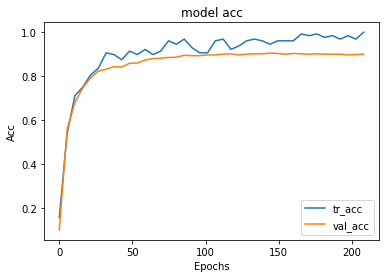

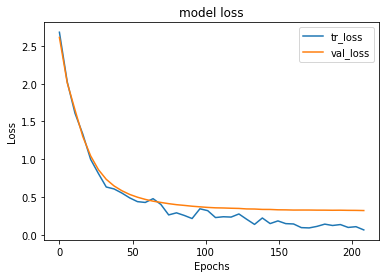

In [8]:
vals_df = pd.DataFrame(vals)
vals_df.columns = ['tr_loss', 'tr_acc', 'val_loss', 'val_acc']
vals_df['epochs'] = (np.asarray(range(len(vals_df))) * 100.0 * 128. / 2400)
plt.plot(vals_df['epochs'],vals_df[["tr_acc","val_acc"]])
plt.legend(['tr_acc', 'val_acc'], loc='lower right')
plt.ylabel("Acc")
plt.xlabel("Epochs")
plt.title("model acc")
plt.show()
plt.plot(vals_df['epochs'],vals_df[["tr_loss","val_loss"]])
plt.legend(['tr_loss', 'val_loss'], loc='upper right')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("model loss")
plt.show()

In [ ]:
!tensorboard --logdir=tmp/fcn_minst_tensorflow/